In [1]:
import pandas as pd

# Load the dataset
mcdonalds = pd.read_csv('mcdonalds.csv')

# Display the column names
print(mcdonalds.columns)

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')


In [3]:
dimensions = mcdonalds.shape
print(dimensions)
print(mcdonalds.head(3))

(1453, 15)
  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


In [4]:
import numpy as np

# Convert the first 11 columns to a NumPy matrix
MD_x = mcdonalds.iloc[:, 0:11].values

# Convert "Yes" to 1 and other values to 0
MD_x = (MD_x == "Yes").astype(int)

# Calculate the column means and round to 2 decimal places
column_means = np.round(np.mean(MD_x, axis=0), 2)
print(column_means)

[0.55 0.91 0.09 0.87 0.53 0.9  0.6  0.64 0.36 0.2  0.24]


In [5]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
MD_pca = pca.fit_transform(MD_x)

# Get a summary of the PCA results
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Print the explained variance and cumulative variance
print("Explained Variance:", np.round(explained_variance, 4))
print("Cumulative Variance:", np.round(cumulative_variance, 4))


Explained Variance: [0.2994 0.1928 0.133  0.0831 0.0595 0.0503 0.0438 0.0395 0.0368 0.0324
 0.0293]
Cumulative Variance: [0.2994 0.4922 0.6253 0.7084 0.7679 0.8182 0.862  0.9016 0.9383 0.9707
 1.    ]


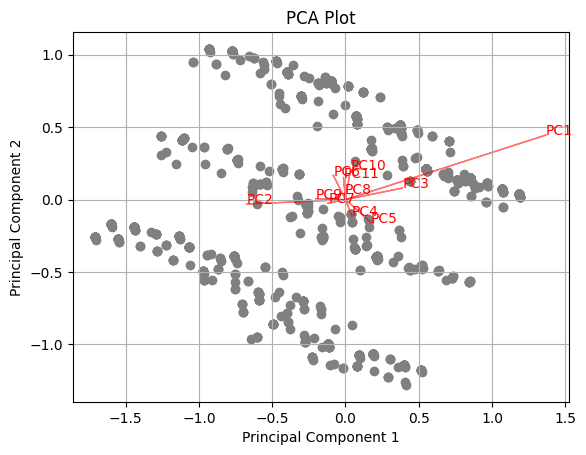

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming MD_pca is already calculated
predictions = pca.transform(MD_x)

# Scatter plot of PCA predictions
plt.scatter(predictions[:, 0], predictions[:, 1], color='grey')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot')

# Plot the principal component axes
for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
    comp_scaled = comp * var * 5  # Scale for visibility
    plt.arrow(0, 0, comp_scaled[0], comp_scaled[1], color='r', alpha=0.5)
    plt.text(comp_scaled[0], comp_scaled[1], f'PC{i+1}', color='r')

plt.grid(True)
plt.show()


In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Set random seed for reproducibility
np.random.seed(1234)

# Range of cluster numbers to evaluate
cluster_range = range(2, 9)
best_kmeans = None
best_score = -1
best_labels = None

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
    kmeans.fit(MD_x)
    labels = kmeans.labels_
    score = silhouette_score(MD_x, labels)

    if score > best_score:
        best_score = score
        best_kmeans = kmeans
        best_labels = labels

# Relabel the clusters to ensure consistency
def relabel_clusters(labels):
    unique_labels = np.unique(labels)
    relabeled = np.zeros_like(labels)
    for i, label in enumerate(unique_labels):
        relabeled[labels == label] = i
    return relabeled

relabelled_labels = relabel_clusters(best_labels)

# Print the results
print("Best number of clusters:", best_kmeans.n_clusters)
print("Best silhouette score:", best_score)
print("Relabelled cluster labels:", relabelled_labels)


Best number of clusters: 8
Best silhouette score: 0.2858643776878159
Relabelled cluster labels: [1 0 0 ... 5 2 3]


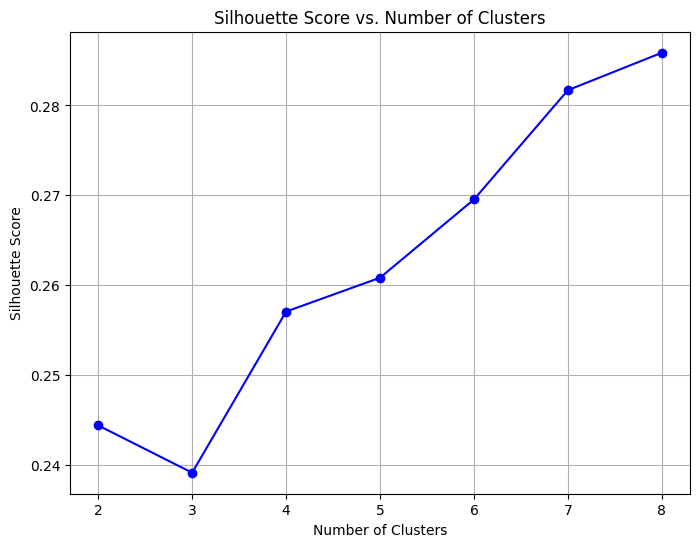

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Set random seed for reproducibility
np.random.seed(1234)

# Range of cluster numbers to evaluate
cluster_range = range(2, 9)
scores = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
    kmeans.fit(MD_x)
    labels = kmeans.labels_
    score = silhouette_score(MD_x, labels)
    scores.append(score)

# Plotting the silhouette scores for different numbers of clusters
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)
plt.show()


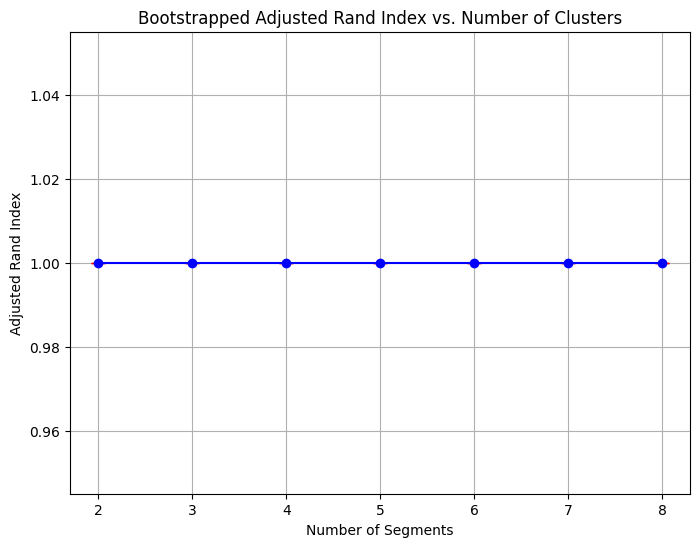

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample

# Set random seed for reproducibility
np.random.seed(1234)

# Function to perform bootstrapping and calculate adjusted Rand index
def bootstrap_kmeans(data, n_clusters, nrep=10, nboot=100):
    rand_indices = []
    for _ in range(nboot):
        bootstrap_sample = resample(data, replace=True, n_samples=len(data))
        best_kmeans = None
        best_score = -1
        best_labels = None
        for _ in range(nrep):
            kmeans = KMeans(n_clusters=n_clusters, n_init=1, random_state=None)
            kmeans.fit(bootstrap_sample)
            labels = kmeans.labels_
            score = adjusted_rand_score(labels, kmeans.predict(data))
            if score > best_score:
                best_score = score
                best_kmeans = kmeans
                best_labels = labels
        rand_index = adjusted_rand_score(best_labels, best_kmeans.labels_)
        rand_indices.append(rand_index)
    return np.mean(rand_indices), np.std(rand_indices)

# Range of cluster numbers to evaluate
cluster_range = range(2, 9)
mean_rand_indices = []
std_rand_indices = []

for n_clusters in cluster_range:
    mean_ari, std_ari = bootstrap_kmeans(MD_x, n_clusters, nrep=10, nboot=100)
    mean_rand_indices.append(mean_ari)
    std_rand_indices.append(std_ari)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.errorbar(cluster_range, mean_rand_indices, yerr=std_rand_indices, fmt='-o', color='b', ecolor='r', capsize=5)
plt.xlabel('Number of Segments')
plt.ylabel('Adjusted Rand Index')
plt.title('Bootstrapped Adjusted Rand Index vs. Number of Clusters')
plt.grid(True)
plt.show()


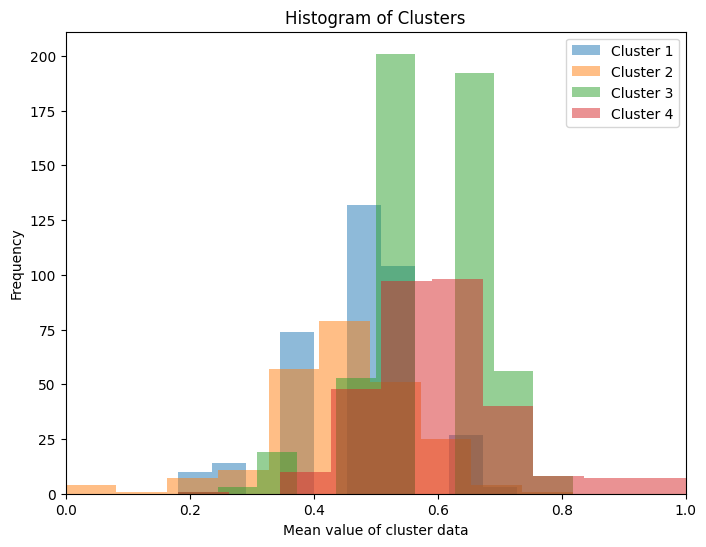

In [11]:
import matplotlib.pyplot as plt

# Assuming best_kmeans is the k-means model with 4 clusters
kmeans_4 = KMeans(n_clusters=4, n_init=10, random_state=1234)
kmeans_4.fit(MD_x)
labels_4 = kmeans_4.labels_

# Create a histogram of cluster assignments
plt.figure(figsize=(8, 6))
for cluster in range(4):
    cluster_data = MD_x[labels_4 == cluster]
    plt.hist(cluster_data.mean(axis=1), bins=10, alpha=0.5, label=f'Cluster {cluster+1}')

plt.xlim(0, 1)
plt.xlabel('Mean value of cluster data')
plt.ylabel('Frequency')
plt.title('Histogram of Clusters')
plt.legend()
plt.show()


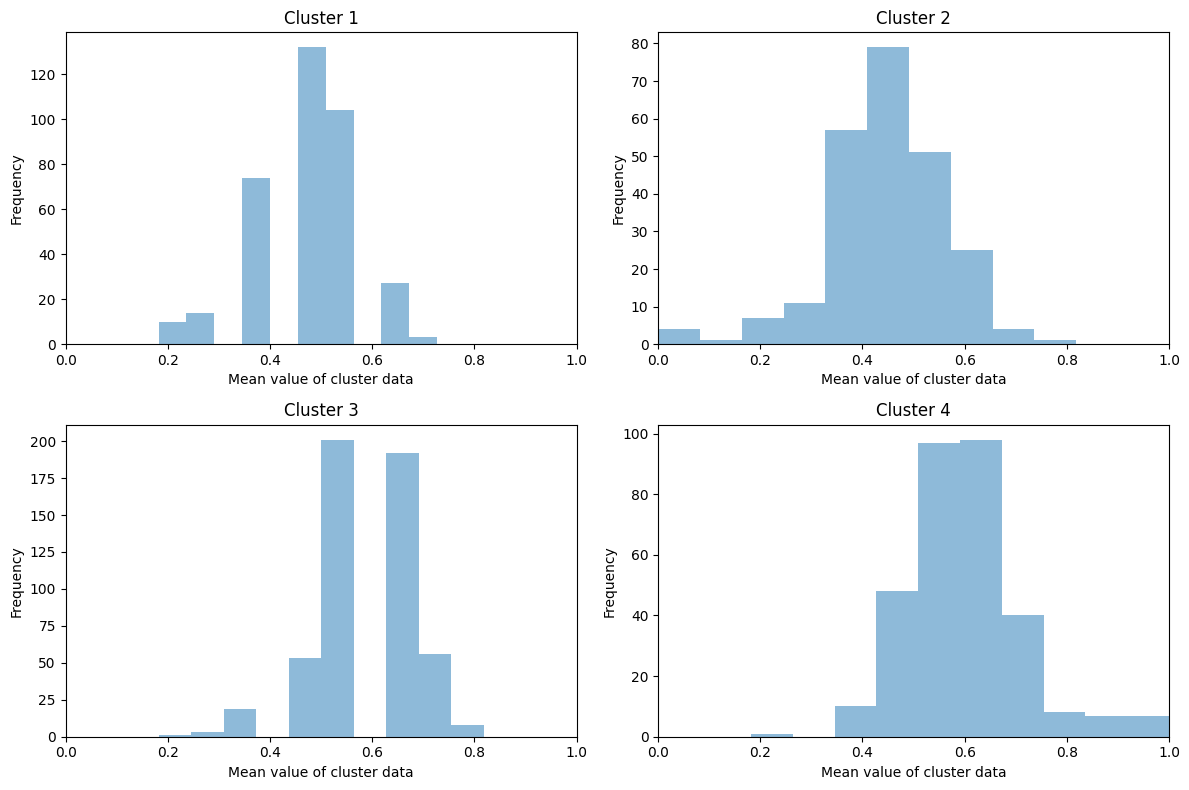

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# Assuming MD_x is the data matrix
# Assuming best_kmeans is the k-means model with 4 clusters
kmeans_4 = KMeans(n_clusters=4, n_init=10, random_state=1234)
kmeans_4.fit(MD_x)
labels_4 = kmeans_4.labels_

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for cluster in range(4):
    cluster_data = MD_x[labels_4 == cluster]
    axes[cluster].hist(cluster_data.mean(axis=1), bins=10, alpha=0.5)
    axes[cluster].set_xlim(0, 1)
    axes[cluster].set_xlabel('Mean value of cluster data')
    axes[cluster].set_ylabel('Frequency')
    axes[cluster].set_title(f'Cluster {cluster+1}')

plt.tight_layout()
plt.show()


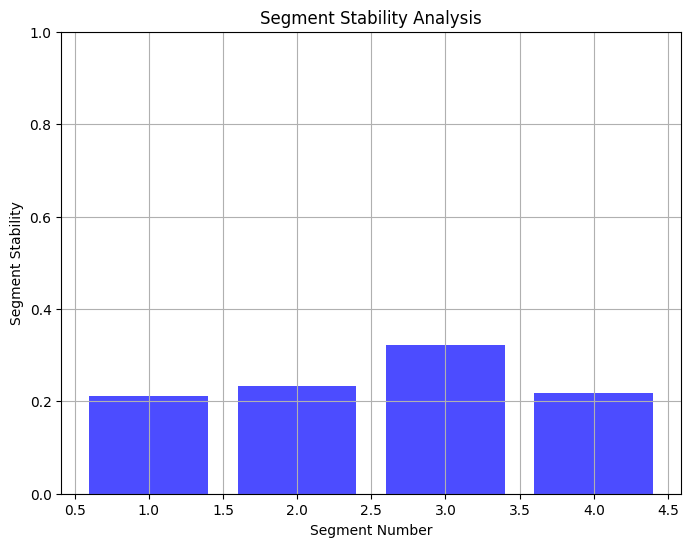

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

# Assuming MD_x is the data matrix
# Fit k-means with 4 clusters
kmeans_4 = KMeans(n_clusters=4, n_init=10, random_state=1234)
kmeans_4.fit(MD_x)
labels_4 = kmeans_4.labels_

# Calculate silhouette scores for each point
silhouette_vals = silhouette_samples(MD_x, labels_4)

# Calculate mean silhouette score for each segment
segment_stability = []
for cluster in range(4):
    cluster_silhouette_vals = silhouette_vals[labels_4 == cluster]
    mean_silhouette = np.mean(cluster_silhouette_vals)
    segment_stability.append(mean_silhouette)

# Plot segment stability
plt.figure(figsize=(8, 6))
plt.bar(range(1, 5), segment_stability, color='blue', alpha=0.7)
plt.ylim(0, 1)
plt.xlabel('Segment Number')
plt.ylabel('Segment Stability')
plt.title('Segment Stability Analysis')
plt.grid(True)
plt.show()


In [14]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Set random seed for reproducibility
np.random.seed(1234)

class BinaryGMM(GaussianMixture):
    def __init__(self, n_components=1, n_init=1, max_iter=100, random_state=None):
        super().__init__(n_components=n_components, n_init=n_init, max_iter=max_iter, random_state=random_state)
    
    def fit(self, X, y=None):
        X_binary = (X > 0.5).astype(int)  # Convert to binary (assuming input is between 0 and 1)
        return super().fit(X_binary, y)
    
    def predict(self, X):
        X_binary = (X > 0.5).astype(int)
        return super().predict(X_binary)

# Range of cluster numbers to evaluate
cluster_range = range(2, 9)
best_models = []

for n_clusters in cluster_range:
    best_gmm = None
    best_score = -1
    
    for _ in range(10):  # nrep = 10
        gmm = BinaryGMM(n_components=n_clusters, n_init=1, random_state=None)
        gmm.fit(MD_x)
        labels = gmm.predict(MD_x)
        score = silhouette_score(MD_x, labels)
        
        if score > best_score:
            best_score = score
            best_gmm = gmm
    
    best_models.append(best_gmm)
    
# Output summary of the best models for each number of clusters
for n_clusters, model in zip(cluster_range, best_models):
    print(f'Number of clusters: {n_clusters}')
    print(f'Model means: {model.means_}')
    print(f'Model covariances: {model.covariances_}\n')


Number of clusters: 2
Model means: [[0.12293578 0.75412844 0.06972477 0.89541284 0.63119266 0.84036697
  0.50458716 0.05137615 0.42752294 0.08073394 0.47889908]
 [0.81057269 1.         0.10792952 0.85022026 0.46365639 0.93612335
  0.65528634 1.         0.3160793  0.26982379 0.10132159]]
Model covariances: [[[ 1.07823574e-01 -8.30569816e-03  6.02642873e-04 -1.28305698e-02
   -1.15411161e-02 -5.58875528e-04 -8.82080633e-03  2.85464187e-02
    6.15773083e-03  8.42353337e-03 -4.41949331e-02]
  [-8.30569816e-03  1.85419736e-01  6.29576634e-04  1.64868277e-02
   -1.54498780e-02  4.14847235e-02  3.41553741e-02 -3.87442134e-02
   -4.35081222e-02  1.50155711e-03 -5.47293999e-02]
  [ 6.02642873e-04  6.29576634e-04  6.48642270e-02 -1.88199646e-03
    3.69665853e-03 -1.71366047e-03 -2.15470078e-03  8.75347168e-05
   -4.51140476e-04  9.04974329e-03  1.47125663e-03]
  [-1.28305698e-02  1.64868277e-02 -1.88199646e-03  9.36496828e-02
    4.58311590e-02  1.44970962e-02  1.24063631e-02 -1.11404764e-02
 

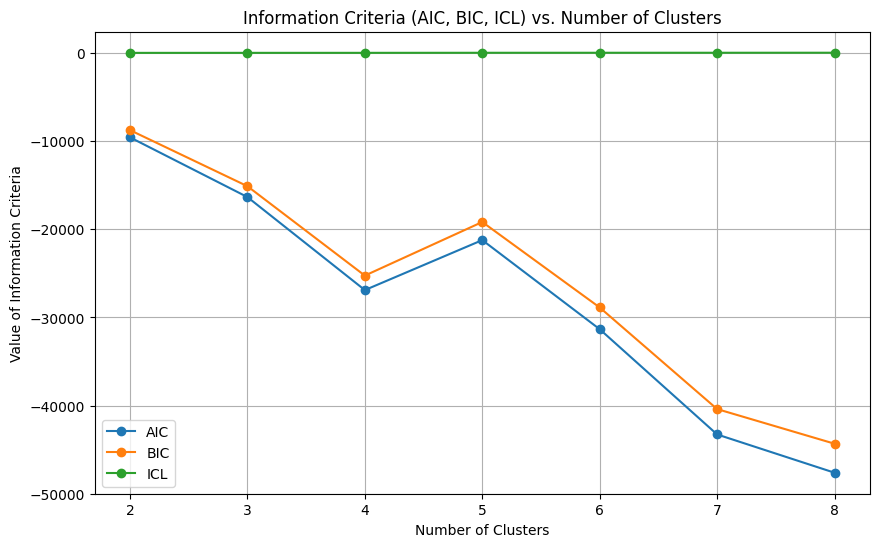

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Set random seed for reproducibility
np.random.seed(1234)

class BinaryGMM(GaussianMixture):
    def __init__(self, n_components=1, n_init=1, max_iter=100, random_state=None):
        super().__init__(n_components=n_components, n_init=n_init, max_iter=max_iter, random_state=random_state)
    
    def fit(self, X, y=None):
        X_binary = (X > 0.5).astype(int)  # Convert to binary (assuming input is between 0 and 1)
        return super().fit(X_binary, y)
    
    def predict(self, X):
        X_binary = (X > 0.5).astype(int)
        return super().predict(X_binary)

# Range of cluster numbers to evaluate
cluster_range = range(2, 9)
aic_values = []
bic_values = []
icl_values = []

for n_clusters in cluster_range:
    best_gmm = None
    best_score = -1
    
    for _ in range(10):  # nrep = 10
        gmm = BinaryGMM(n_components=n_clusters, n_init=1, random_state=None)
        gmm.fit(MD_x)
        labels = gmm.predict(MD_x)
        score = silhouette_score(MD_x, labels)
        
        if score > best_score:
            best_score = score
            best_gmm = gmm
    
    aic_values.append(best_gmm.aic(MD_x))
    bic_values.append(best_gmm.bic(MD_x))
    icl_values.append(-best_gmm.score(MD_x) + np.log(len(MD_x)) * n_clusters * np.log(2))

# Plotting the information criteria
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, aic_values, label='AIC', marker='o')
plt.plot(cluster_range, bic_values, label='BIC', marker='o')
plt.plot(cluster_range, icl_values, label='ICL', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Value of Information Criteria')
plt.title('Information Criteria (AIC, BIC, ICL) vs. Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Assuming MD_x is the data matrix

# Step 1: Fit k-means with 4 clusters
kmeans_4 = KMeans(n_clusters=4, n_init=10, random_state=1234)
kmeans_4.fit(MD_x)
kmeans_labels_4 = kmeans_4.labels_

# Step 2: Extract the best mixture model with 4 clusters from previous results
best_gmm_4 = BinaryGMM(n_components=4, n_init=10, random_state=1234)
best_gmm_4.fit(MD_x)
mixture_labels_4 = best_gmm_4.predict(MD_x)

# Step 3: Create a contingency table
contingency_table = pd.crosstab(kmeans_labels_4, mixture_labels_4, rownames=['kmeans'], colnames=['mixture'])

# Print the contingency table
print(contingency_table)


mixture    0    1    2    3
kmeans                     
0         31   51  268   14
1          4  214    0   22
2        143    0  362   28
3          0    3    0  313


In [17]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Assuming MD_x is the data matrix

# Step 1: Fit k-means with 4 clusters
kmeans_4 = KMeans(n_clusters=4, n_init=10, random_state=1234)
kmeans_4.fit(MD_x)
kmeans_labels_4 = kmeans_4.labels_

# Step 2: Fit a GMM using the k-means clusters as the initial cluster assignments
class BinaryGMM(GaussianMixture):
    def __init__(self, n_components=1, n_init=1, max_iter=100, random_state=None):
        super().__init__(n_components=n_components, n_init=n_init, max_iter=max_iter, random_state=random_state)
    
    def fit(self, X, y=None):
        X_binary = (X > 0.5).astype(int)  # Convert to binary (assuming input is between 0 and 1)
        return super().fit(X_binary, y)
    
    def predict(self, X):
        X_binary = (X > 0.5).astype(int)
        return super().predict(X_binary)

gmm_with_kmeans_init = BinaryGMM(n_components=4, n_init=1, max_iter=100, random_state=1234)
gmm_with_kmeans_init.fit(MD_x, y=kmeans_labels_4)
mixture_labels_4a = gmm_with_kmeans_init.predict(MD_x)

# Step 3: Create a contingency table
contingency_table = pd.crosstab(kmeans_labels_4, mixture_labels_4a, rownames=['kmeans'], colnames=['mixture'])

# Print the contingency table
print(contingency_table)


mixture    0    1    2    3
kmeans                     
0         99    5  253    7
1          0  211   24    5
2        500    0    0   33
3         22   38    0  256


In [18]:
from sklearn.mixture import GaussianMixture

# Assuming MD_x is the data matrix

# Step 1: Fit k-means with 4 clusters
kmeans_4 = KMeans(n_clusters=4, n_init=10, random_state=1234)
kmeans_4.fit(MD_x)
kmeans_labels_4 = kmeans_4.labels_

# Step 2: Fit a GMM using the k-means clusters as the initial cluster assignments
class BinaryGMM(GaussianMixture):
    def __init__(self, n_components=1, n_init=1, max_iter=100, random_state=None):
        super().__init__(n_components=n_components, n_init=n_init, max_iter=max_iter, random_state=random_state)
    
    def fit(self, X, y=None):
        X_binary = (X > 0.5).astype(int)  # Convert to binary (assuming input is between 0 and 1)
        return super().fit(X_binary, y)
    
    def predict(self, X):
        X_binary = (X > 0.5).astype(int)
        return super().predict(X_binary)

# Fit the GMM with initial clusters from k-means
gmm_with_kmeans_init = BinaryGMM(n_components=4, n_init=1, max_iter=100, random_state=1234)
gmm_with_kmeans_init.fit(MD_x, y=kmeans_labels_4)

# Log-likelihood of the GMM with k-means initialization
log_likelihood_kmeans_init = gmm_with_kmeans_init.score(MD_x) * MD_x.shape[0]
print(f'Log Likelihood (GMM with k-means init): {log_likelihood_kmeans_init}')

# Fit the GMM directly
best_gmm_4 = BinaryGMM(n_components=4, n_init=10, random_state=1234)
best_gmm_4.fit(MD_x)

# Log-likelihood of the directly fitted GMM
log_likelihood_direct = best_gmm_4.score(MD_x) * MD_x.shape[0]
print(f'Log Likelihood (Direct GMM): {log_likelihood_direct}')


Log Likelihood (GMM with k-means init): 13740.703879948449
Log Likelihood (Direct GMM): 17513.541902228542


In [22]:
import pandas as pd

# Assuming mcdonalds is the DataFrame
mcdonalds = pd.read_csv('mcdonalds.csv')

# Step 1: Reverse the frequency table of the `Like` column
like_counts = mcdonalds['Like'].value_counts().sort_index(ascending=False)
print("Reversed frequency table of 'Like':")
print(like_counts)

# Step 2: Map the `Like` column to numeric values
like_mapping = {
    'I love it!+5': 5,
    'I like it+4': 4,
    'It\'s okay+3': 3,
    'I don\'t like it+2': 2,
    'I hate it!+1': 1
}
mcdonalds['Like.n'] = mcdonalds['Like'].map(like_mapping)

# Step 3: Transform the `Like.n` column
mcdonalds['Like.n'] = 6 - mcdonalds['Like.n']

# Step 4: Frequency table of the new `Like.n` column
like_n_counts = mcdonalds['Like.n'].value_counts().sort_index()
print("Frequency table of 'Like.n':")
print(like_n_counts)







Reversed frequency table of 'Like':
Like
I love it!+5    143
I hate it!-5    152
0               169
-4               71
-3               73
-2               59
-1               58
+4              160
+3              229
+2              187
+1              152
Name: count, dtype: int64
Frequency table of 'Like.n':
Like.n
1.0    143
Name: count, dtype: int64


In [27]:
import pandas as pd
import patsy

# Load the dataset
mcdonalds = pd.read_csv('mcdonalds.csv')

# Ensure the column names do not have spaces or special characters
mcdonalds.columns = [col.strip().replace(' ', '_') for col in mcdonalds.columns]

# Print columns to verify
print("Columns in DataFrame:", mcdonalds.columns)

# Check if 'Like_n' (or similar) exists and correct the column name
# Ensure 'Like.n' is transformed to 'Like_n' or use its exact name
if 'Like_n' not in mcdonalds.columns:
    if 'Like' in mcdonalds.columns:
        mcdonalds.rename(columns={'Like': 'Like_n'}, inplace=True)
    else:
        raise ValueError("The column 'Like' or 'Like_n' does not exist in the DataFrame.")

# Step 1: Create the formula string for the model
predictors = "+".join(mcdonalds.columns[1:12])  # Adjust the indices based on the position of 'Like_n'
formula = f"Like_n ~ {predictors}"

# Print the formula string
print(f"Formula: {formula}")

# Convert the formula string to a Patsy formula
try:
    y, X = patsy.dmatrices(formula, data=mcdonalds, return_type='dataframe')
    print("Design matrices successfully created.")
    # Print the first few rows of the design matrices to verify
    print(y.head())
    print(X.head())
except Exception as e:
    print("Error:", e)


Columns in DataFrame: Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')
Formula: Like_n ~ convenient+spicy+fattening+greasy+fast+cheap+tasty+expensive+healthy+disgusting+Like_n
Design matrices successfully created.
   Like_n[+1]  Like_n[+2]  Like_n[+3]  Like_n[+4]  Like_n[-1]  Like_n[-2]  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         1.0         0.0         0.0         0.0         0.0   
2         1.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         1.0         0.0         0.0   
4         0.0         1.0         0.0         0.0         0.0         0.0   

   Like_n[-3]  Like_n[-4]  Like_n[0]  Like_n[I hate it!-5]  \
0         1.0         0.0        0.0                   0.0   
1         0.0         0.0        0.0      

In [29]:
import pandas as pd
import patsy
import statsmodels.api as sm
from sklearn.mixture import GaussianMixture

# Load the dataset
mcdonalds = pd.read_csv('mcdonalds.csv')

# Ensure the column names are valid
mcdonalds.columns = [col.strip().replace(' ', '_') for col in mcdonalds.columns]

# Check if 'Like_n' exists or rename if needed
if 'Like_n' not in mcdonalds.columns:
    if 'Like' in mcdonalds.columns:
        mcdonalds.rename(columns={'Like': 'Like_n'}, inplace=True)
    else:
        raise ValueError("The column 'Like' or 'Like_n' does not exist in the DataFrame.")

# Step 1: Create the formula string for the model
predictors = "+".join(mcdonalds.columns[1:12])  # Adjust indices based on the position of 'Like_n'
formula = f"Like_n ~ {predictors}"

# Convert the formula string to a Patsy formula
y, X = patsy.dmatrices(formula, data=mcdonalds, return_type='dataframe')

# Step 2: Fit the regression model (for k=2, we fit two Gaussian Mixture Models)
# Here we are fitting a Gaussian Mixture Model as an example
gmm = GaussianMixture(n_components=2, n_init=10, random_state=1234)
gmm.fit(X)

# Display the fitted model
print("Gaussian Mixture Model:")
print(gmm)

# Predict the cluster assignments
cluster_assignments = gmm.predict(X)
print("Cluster assignments:")
print(cluster_assignments)


Gaussian Mixture Model:
GaussianMixture(n_components=2, n_init=10, random_state=1234)
Cluster assignments:
[0 1 1 ... 1 1 0]


In [30]:
import pandas as pd
import patsy
import statsmodels.api as sm
from sklearn.mixture import GaussianMixture
import numpy as np

# Load the dataset
mcdonalds = pd.read_csv('mcdonalds.csv')

# Ensure the column names are valid
mcdonalds.columns = [col.strip().replace(' ', '_') for col in mcdonalds.columns]

# Check if 'Like_n' exists or rename if needed
if 'Like_n' not in mcdonalds.columns:
    if 'Like' in mcdonalds.columns:
        mcdonalds.rename(columns={'Like': 'Like_n'}, inplace=True)
    else:
        raise ValueError("The column 'Like' or 'Like_n' does not exist in the DataFrame.")

# Step 1: Create the formula string for the model
predictors = "+".join(mcdonalds.columns[1:12])  # Adjust indices based on the position of 'Like_n'
formula = f"Like_n ~ {predictors}"

# Convert the formula string to a Patsy formula
y, X = patsy.dmatrices(formula, data=mcdonalds, return_type='dataframe')

# Step 2: Fit the initial Gaussian Mixture Model (k=2)
gmm = GaussianMixture(n_components=2, n_init=10, random_state=1234)
gmm.fit(X)

# Refitting the model
gmm_refit = GaussianMixture(n_components=2, n_init=10, random_state=1234)
gmm_refit.fit(X)

# Print summary information
print("Gaussian Mixture Model (Refitted):")
print("Means:")
print(gmm_refit.means_)

print("Covariances:")
print(gmm_refit.covariances_)

print("Weights:")
print(gmm_refit.weights_)

print("Converged:", gmm_refit.converged_)
print("Number of Iterations:", gmm_refit.n_iter_)


Gaussian Mixture Model (Refitted):
Means:
[[1.         0.80756014 0.10652921 0.91924399 0.66323024 0.85051546
  0.51890034 0.29896907 0.42268041 0.0790378  0.5        0.
  0.         0.         0.09965636 0.10137457 0.12542955 0.12199313
  0.29037801 0.26116838 0.        ]
 [1.         0.97474168 0.08495982 0.83237658 0.43513203 0.93340987
  0.652124   0.87485649 0.31458094 0.27898967 0.07118255 0.21469575
  0.26291619 0.1836969  0.         0.         0.         0.
  0.         0.         0.1641791 ]]
Covariances:
[[[ 1.00000000e-06  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00]
  [ 0.00000000e+00  1.55407762e-01  8.47297505e-03  1.02325197e-02
   -1.32615345e-02  4.16799518e-02  3.45650146e-02  4.0351

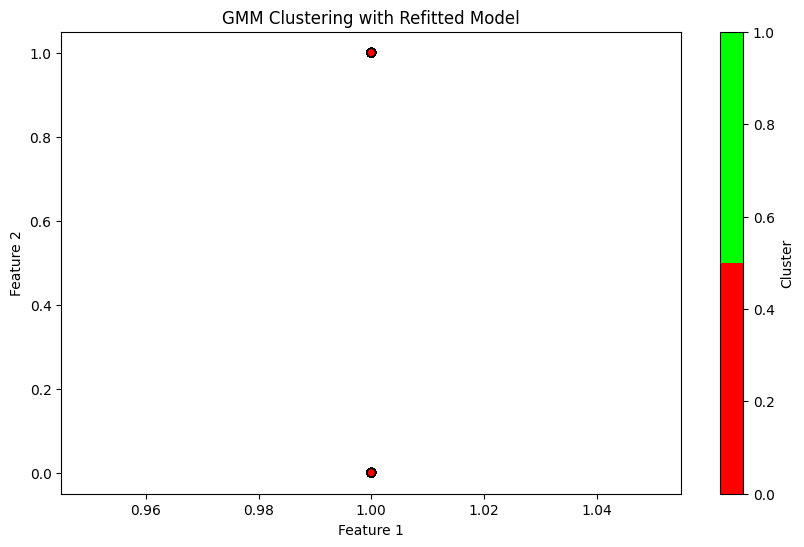

In [31]:
import pandas as pd
import patsy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from matplotlib.colors import ListedColormap

# Load the dataset
mcdonalds = pd.read_csv('mcdonalds.csv')

# Ensure the column names are valid
mcdonalds.columns = [col.strip().replace(' ', '_') for col in mcdonalds.columns]

# Check if 'Like_n' exists or rename if needed
if 'Like_n' not in mcdonalds.columns:
    if 'Like' in mcdonalds.columns:
        mcdonalds.rename(columns={'Like': 'Like_n'}, inplace=True)
    else:
        raise ValueError("The column 'Like' or 'Like_n' does not exist in the DataFrame.")

# Step 1: Create the formula string for the model
predictors = "+".join(mcdonalds.columns[1:12])  # Adjust indices based on the position of 'Like_n'
formula = f"Like_n ~ {predictors}"

# Convert the formula string to a Patsy formula
y, X = patsy.dmatrices(formula, data=mcdonalds, return_type='dataframe')

# Fit the initial Gaussian Mixture Model (k=2)
gmm = GaussianMixture(n_components=2, n_init=10, random_state=1234)
gmm.fit(X)

# Refitting the model
gmm_refit = GaussianMixture(n_components=2, n_init=10, random_state=1234)
gmm_refit.fit(X)

# Predict cluster assignments
cluster_assignments = gmm_refit.predict(X)

# Plotting the data points and cluster assignments
plt.figure(figsize=(10, 6))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=cluster_assignments, cmap=ListedColormap(['#FF0000', '#00FF00']), edgecolor='k')
plt.title('GMM Clustering with Refitted Model')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()


C:\Users\arpma\AppData\Local\Temp\ipykernel_14016\2651044280.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  MD_x = mcdonalds.iloc[:, 0:11].applymap(lambda x: 1 if x == "Yes" else 0).values


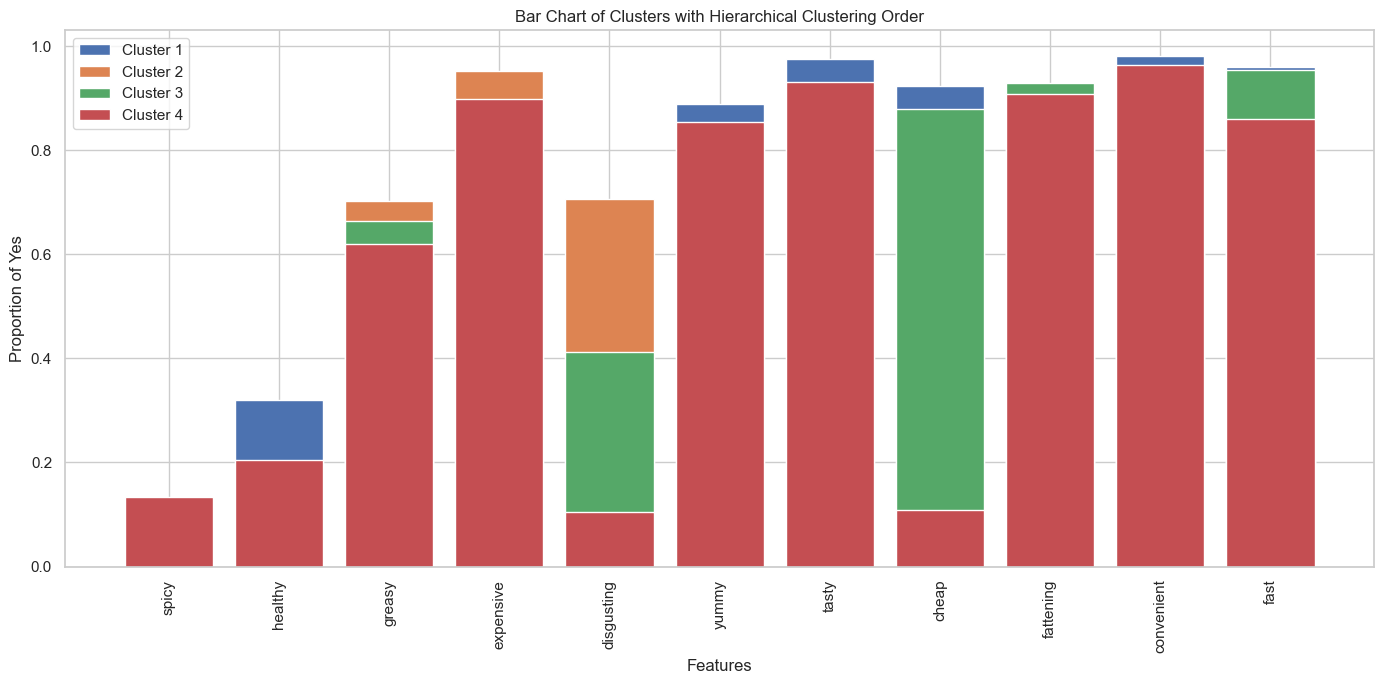

In [32]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Load the dataset
mcdonalds = pd.read_csv('mcdonalds.csv')

# Convert Yes/No to 1/0
MD_x = mcdonalds.iloc[:, 0:11].applymap(lambda x: 1 if x == "Yes" else 0).values

# Hierarchical clustering on the transposed matrix
MD_vclust = linkage(MD_x.T, method='ward')

# Order of features based on hierarchical clustering
order = leaves_list(MD_vclust)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=1234)
kmeans.fit(MD_x)
cluster_labels = kmeans.labels_

# Create a DataFrame for plotting
df_plot = pd.DataFrame(MD_x, columns=mcdonalds.columns[0:11])
df_plot['Cluster'] = cluster_labels

# Reorder the columns based on hierarchical clustering
ordered_columns = [mcdonalds.columns[i] for i in order]
df_plot = df_plot[ordered_columns + ['Cluster']]

# Plotting the bar chart
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

# Create a stacked bar plot
for cluster in np.unique(cluster_labels):
    subset = df_plot[df_plot['Cluster'] == cluster]
    means = subset.mean()
    plt.bar(range(len(order)), means[:-1], label=f'Cluster {cluster + 1}')

plt.xticks(range(len(order)), ordered_columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Proportion of Yes')
plt.title('Bar Chart of Clusters with Hierarchical Clustering Order')
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\arpma\AppData\Local\Temp\ipykernel_14016\370963207.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  MD_x = mcdonalds.iloc[:, 0:11].applymap(lambda x: 1 if x == "Yes" else 0).values


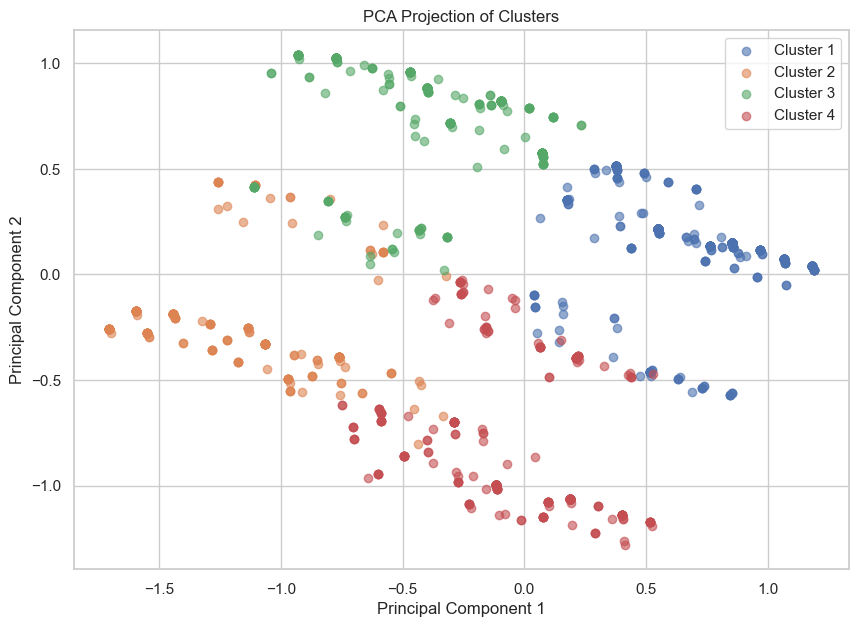

In [33]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the dataset
mcdonalds = pd.read_csv('mcdonalds.csv')

# Convert Yes/No to 1/0
MD_x = mcdonalds.iloc[:, 0:11].applymap(lambda x: 1 if x == "Yes" else 0).values

# Perform PCA
pca = PCA(n_components=2)
MD_pca = pca.fit_transform(MD_x)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=1234)
cluster_labels = kmeans.fit_predict(MD_x)

# Plotting the PCA projection
plt.figure(figsize=(10, 7))

# Scatter plot of PCA components colored by cluster
for cluster in np.unique(cluster_labels):
    plt.scatter(MD_pca[cluster_labels == cluster, 0], 
                MD_pca[cluster_labels == cluster, 1], 
                label=f'Cluster {cluster + 1}', alpha=0.6)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection of Clusters')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\arpma\AppData\Local\Temp\ipykernel_14016\2096367681.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  MD_x = mcdonalds.iloc[:, 0:11].applymap(lambda x: 1 if x == "Yes" else 0).values


<Figure size 1000x700 with 0 Axes>

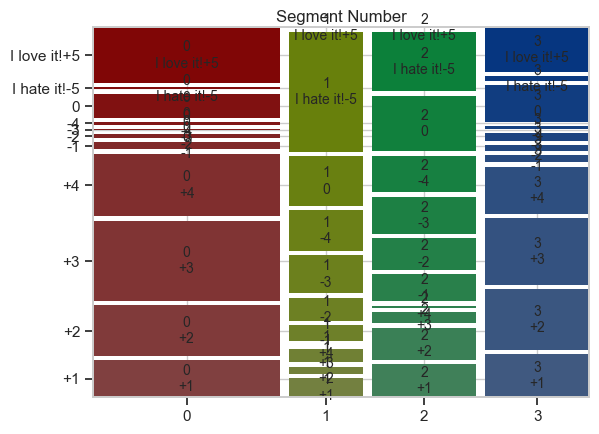

In [34]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# Load the dataset
mcdonalds = pd.read_csv('mcdonalds.csv')

# Convert Yes/No to 1/0
MD_x = mcdonalds.iloc[:, 0:11].applymap(lambda x: 1 if x == "Yes" else 0).values

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=1234)
cluster_labels = kmeans.fit_predict(MD_x)

# Create a contingency table
contingency_table = pd.crosstab(cluster_labels, mcdonalds['Like'])

# Plotting the mosaic plot
plt.figure(figsize=(10, 7))
mosaic(contingency_table.stack(), title='', gap=0.02)
plt.xlabel('Segment Number')
plt.show()


C:\Users\arpma\AppData\Local\Temp\ipykernel_14016\4267121372.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  MD_x = mcdonalds.iloc[:, 0:11].applymap(lambda x: 1 if x == "Yes" else 0).values


<Figure size 1000x700 with 0 Axes>

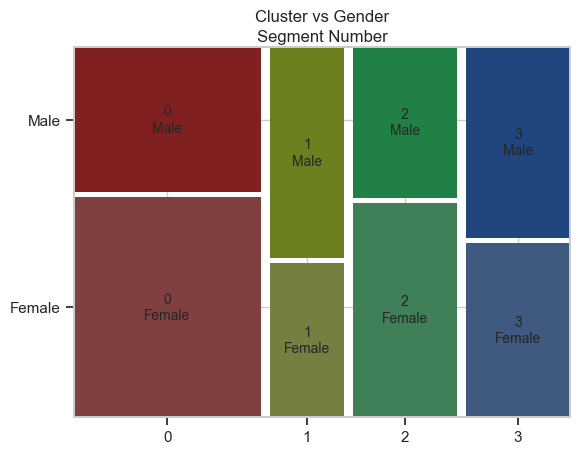

In [35]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# Load the dataset
mcdonalds = pd.read_csv('mcdonalds.csv')

# Convert Yes/No to 1/0
MD_x = mcdonalds.iloc[:, 0:11].applymap(lambda x: 1 if x == "Yes" else 0).values

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=1234)
cluster_labels = kmeans.fit_predict(MD_x)

# Create a contingency table for clusters and Gender
contingency_table = pd.crosstab(cluster_labels, mcdonalds['Gender'])

# Plotting the mosaic plot
plt.figure(figsize=(10, 7))
mosaic(contingency_table.stack(), title='Cluster vs Gender', gap=0.02)
plt.xlabel('Segment Number')
plt.show()


C:\Users\arpma\AppData\Local\Temp\ipykernel_14016\3729148942.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  MD_x = mcdonalds.iloc[:, 0:11].applymap(lambda x: 1 if x == "Yes" else 0).values


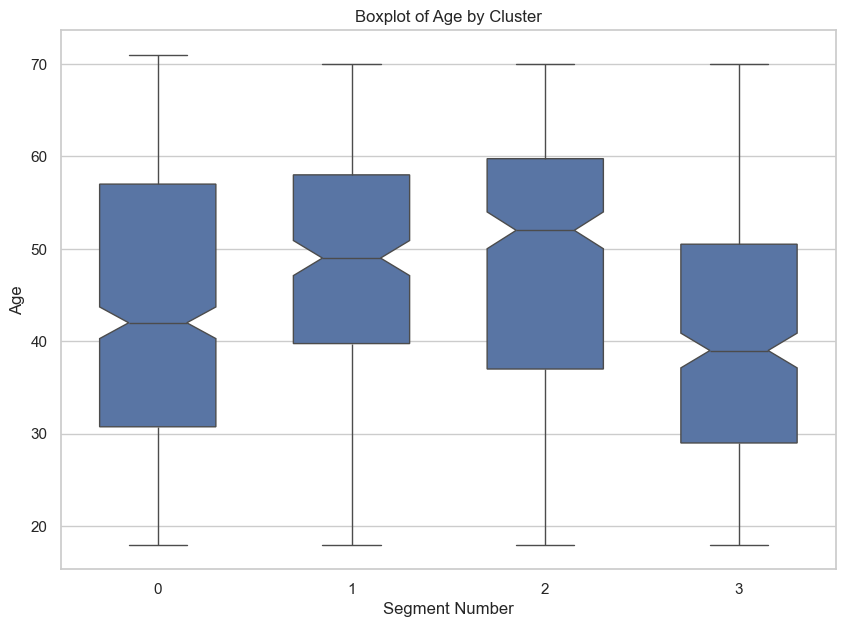

In [36]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
mcdonalds = pd.read_csv('mcdonalds.csv')

# Convert Yes/No to 1/0
MD_x = mcdonalds.iloc[:, 0:11].applymap(lambda x: 1 if x == "Yes" else 0).values

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=1234)
cluster_labels = kmeans.fit_predict(MD_x)

# Add cluster labels to the DataFrame
mcdonalds['Cluster'] = cluster_labels

# Plotting the boxplot
plt.figure(figsize=(10, 7))
sns.boxplot(x='Cluster', y='Age', data=mcdonalds, notch=True, width=0.6)
plt.xlabel('Segment Number')
plt.ylabel('Age')
plt.title('Boxplot of Age by Cluster')
plt.show()
